In [11]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import numpy as np
import scipy.io
import argparse


In [12]:
# argparser = argparse.ArgumentParser()
# argparser.add_argument('--load', default=0, type=int, help='load model', required=False)
# argparser.add_argument('--save', default=1, type=int, help='save model', required=False) 
# argparser.add_argument('--train', default=1, type=int, help='train model', required=False)

# args = argparser.parse_args()

# load = args.load
# save = args.save
# train = args.train

load=1
save=1
train=1

random_seed = 42
torch.manual_seed(random_seed)

device = torch.device('cuda' if not torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 32
num_epochs = 100
latent_size = 128
g_learning_rate = 0.002
d_learning_rate = 0.002
e_learning_rate = 0.002
limit = batch_size * 512
image_size = 64

train_generator = True
train_discriminator = True
train_encoder = False


In [13]:
# Load Data
dir = 'wiki_crop/'
mat = scipy.io.loadmat(dir + 'wiki.mat')
wiki = mat['wiki']
wiki = wiki[0][0]

dob = wiki[0][0]
photo_taken = wiki[1][0]
full_path = wiki[2][0]
gender = wiki[3][0]
name = wiki[4][0]
face_location = wiki[5][0]
face_score = wiki[6][0]
second_face_score = wiki[7][0]



In [14]:
age = []
for i in range(len(dob)):
    birth_year = int(str(dob[i])[0:2])
    if birth_year > 20:
        birth_year += 1900
    else:
        birth_year += 2000
    age.append(photo_taken[i] - birth_year)
    if age[i] < 0:
        age[i] += 100
age = torch.tensor(age)

# sort by face_score
face_score = torch.tensor(face_score)
face_score, indices = torch.sort(face_score, descending=True)
age = age[indices]
full_path = full_path[indices]
face_location = face_location[indices]
face_location_int = []
for i in range(len(face_location)):
    face_location_int.append([])
    for j in range(len(face_location[i][0])):
        face_location_int[i].append(int(face_location[i][0][j]))

# print(type(face_location_int[0][0]))
face_location = face_location_int

# Load Images
all_images = []
error_count = 0
size = 0
for i in range(min(len(full_path), limit)):
    try:
        image = plt.imread(dir + full_path[i][0])
        # print(image.shape)
        all_images.append(image)
        # size += image.shape[0] * image.shape[1] * image.shape[2]
    except:
        error_count += 1
        all_images.append(all_images[i - 1])

print(error_count)
print(len(all_images))
# print(size)
# exit(0)
# print(face_location.shape)


21
16384


In [15]:
# Preprocess Images
def test(image):
    image = torch.tensor(image).cpu()
    image = image.reshape(3, image_size, image_size)
    image = image.permute(1, 2, 0)
    image = image * 255
    image = image.numpy()
    image = image.astype(np.uint8)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


for i in range(len(all_images)):
    temp = all_images[i][face_location[i][1]:face_location[i][3], face_location[i][0]:face_location[i][2]]
    if temp.shape[0] == 0 or temp.shape[1] == 0:
        temp = all_images[i]
    all_images[i] = temp

def preprocess(image):
    
    while image.shape[0] == 0 or image.shape[1] == 0:
        image = all_images[np.random.randint(0, len(all_images) - 1)]
    
    
    if len(image.shape) == 2:
        image = np.stack((image,) * 3, axis=-1)
    if image.shape[2] >= 4:
        image = image[:, :, :3]
    # print(image.shape)
    # resize image to image_size x image_size
    image = torch.tensor(image)
    image = image.permute(2, 0, 1)
    image = image.float()
    image = image / 255
    # print(image.shape)
    image = F.interpolate(image.unsqueeze(0), size=image_size, mode='bilinear', align_corners=False).squeeze(0)
    # print(image.shape)
    # test(image)
    return image

all_images = [preprocess(image) for i, image in enumerate(all_images)]
# exit(0)

In [16]:
# Create Dataset
class WikiDataset(torch.utils.data.Dataset):
    def __init__(self, images, age):
        self.images = images
        self.age = age

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index], self.age[index]

dataset = WikiDataset(all_images, age)
train_dataset = dataset
# Create DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


In [17]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # input: 3x64x64
        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)
    
        

In [18]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(latent_size, 2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            
            nn.Linear(2048, 16384),
            nn.BatchNorm1d(16384),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            
            nn.Unflatten(1, (256, 8, 8)),
            
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 3, kernel_size=5, padding=2),
            nn.Tanh()
        )

    def forward(self, x):
        return self.layers(x)


In [19]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=4, stride=2), # 16x31x31
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2), # 32x14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), # 64x6x6
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 6 * 6, latent_size),
            nn.Sigmoid(),
            #reverse the process of generator
            nn.Linear(latent_size, 64 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),    # 32x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),    # 16x32x32
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),     # 3x64x64
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)
    
    def encode(self, x):
        return self.layers[:9](x)

In [20]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
encoder = Encoder().to(device)

# load model
if load:
    discriminator.load_state_dict(torch.load('discriminator.ckpt'))
    generator.load_state_dict(torch.load('generator.ckpt'))
    # encoder.load_state_dict(torch.load('encoder.ckpt'))

# Loss and optimizer
criterion = nn.BCELoss()
criterion2 = nn.MSELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=d_learning_rate, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=g_learning_rate, betas=(0.5, 0.999))
e_optimizer = optim.Adam(encoder.parameters(), lr=e_learning_rate, betas=(0.5, 0.999))
# schdular
d_scheduler = optim.lr_scheduler.StepLR(d_optimizer, step_size=5, gamma=0.9)
g_scheduler = optim.lr_scheduler.StepLR(g_optimizer, step_size=5, gamma=0.9)
e_scheduler = optim.lr_scheduler.StepLR(e_optimizer, step_size=5, gamma=0.9)


total_step = len(train_loader)
d_losses, g_losses, e_losses = [], [], []


def plot():
    with torch.no_grad():
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = generator(z).cpu()
        fake_images = fake_images.reshape(fake_images.size(0), 3, image_size, image_size)
        fake_images = fake_images.permute(0, 2, 3, 1)
        fake_images = fake_images * 255
        fake_images = fake_images.numpy()
        fake_images = fake_images.astype(np.uint8)
        for i in range(10):
            plt.subplot(2, 5, i + 1)
            plt.imshow(fake_images[i])
            plt.axis('off')
        plt.show()

        # test encoder fake image
        real_images = all_images[:batch_size]
        real_images = torch.stack(real_images)
        real_images = real_images.to(device)
        fake_images = encoder(real_images).cpu()
        fake_images = fake_images.reshape(fake_images.size(0), 3, image_size, image_size)
        fake_images = fake_images.permute(0, 2, 3, 1)
        fake_images = fake_images * 255
        fake_images = fake_images.numpy()
        fake_images = fake_images.astype(np.uint8)
        for i in range(10):
            plt.subplot(2, 5, i + 1)
            plt.imshow(fake_images[i])
            plt.axis('off')
        plt.show()


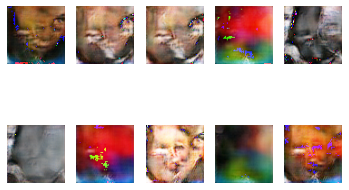

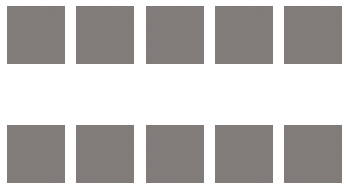

epoch 1/100, step 100/512, d_loss = 0.1463, g_loss = 14.1590, e_loss = 0.0000
epoch 1/100, step 200/512, d_loss = 0.0546, g_loss = 10.3881, e_loss = 0.0000
epoch 1/100, step 300/512, d_loss = 0.3271, g_loss = 14.4904, e_loss = 0.0000
epoch 1/100, step 400/512, d_loss = 0.0021, g_loss = 10.0250, e_loss = 0.0000
epoch 1/100, step 500/512, d_loss = 0.0915, g_loss = 5.5324, e_loss = 0.0000
epoch 2/100, step 100/512, d_loss = 0.0002, g_loss = 9.0142, e_loss = 0.0000
epoch 2/100, step 200/512, d_loss = 0.0462, g_loss = 8.1016, e_loss = 0.0000
epoch 2/100, step 300/512, d_loss = 0.0790, g_loss = 5.5167, e_loss = 0.0000
epoch 2/100, step 400/512, d_loss = 0.0103, g_loss = 10.7845, e_loss = 0.0000
epoch 2/100, step 500/512, d_loss = 0.2008, g_loss = 14.2239, e_loss = 0.0000
epoch 3/100, step 100/512, d_loss = 0.0266, g_loss = 11.6491, e_loss = 0.0000
epoch 3/100, step 200/512, d_loss = 0.0525, g_loss = 3.7967, e_loss = 0.0000
epoch 3/100, step 300/512, d_loss = 0.0983, g_loss = 11.3947, e_loss 

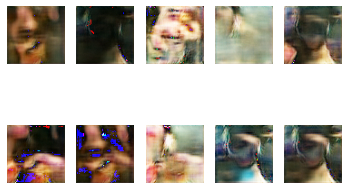

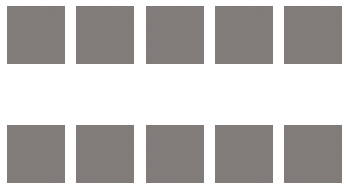

epoch 6/100, step 100/512, d_loss = 0.0246, g_loss = 12.7016, e_loss = 0.0000
epoch 6/100, step 200/512, d_loss = 0.1240, g_loss = 11.4311, e_loss = 0.0000
epoch 6/100, step 300/512, d_loss = 0.0014, g_loss = 9.2565, e_loss = 0.0000
epoch 6/100, step 400/512, d_loss = 0.0009, g_loss = 6.9549, e_loss = 0.0000
epoch 6/100, step 500/512, d_loss = 0.0942, g_loss = 4.5262, e_loss = 0.0000
epoch 7/100, step 100/512, d_loss = 0.0098, g_loss = 10.6069, e_loss = 0.0000
epoch 7/100, step 200/512, d_loss = 0.0136, g_loss = 13.5438, e_loss = 0.0000
epoch 7/100, step 300/512, d_loss = 0.0786, g_loss = 7.8459, e_loss = 0.0000
epoch 7/100, step 400/512, d_loss = 0.0549, g_loss = 22.3535, e_loss = 0.0000


KeyboardInterrupt: 

In [21]:

# Train the model
if train:
    for epoch in range(num_epochs):
        if (epoch) % 5 == 0:
            plot()
            if save:
                if train_discriminator:
                    torch.save(discriminator.state_dict(), 'discriminator.ckpt')
                if train_generator:
                    torch.save(generator.state_dict(), 'generator.ckpt')
                if train_encoder:
                    torch.save(encoder.state_dict(), 'encoder.ckpt')
                
        for i, (images, _) in enumerate(train_loader):
            g_loss, d_loss, e_loss = torch.tensor(0), torch.tensor(0), torch.tensor(0)
            # train generator
            if train_generator:
                g_optimizer.zero_grad()
                z = torch.randn(batch_size, latent_size).to(device)
                fake_images = generator(z)
                outputs = discriminator(fake_images)
                g_loss = criterion(outputs, torch.ones_like(outputs))
                g_loss.backward()
                g_optimizer.step()

            # train discriminator
            if train_discriminator:
                d_optimizer.zero_grad()
                real_images = images.to(device)
                outputs = discriminator(real_images)
                real_loss = criterion(outputs, torch.ones_like(outputs))
                z = torch.randn(batch_size, latent_size).to(device)
                fake_images = generator(z).detach()
                outputs = discriminator(fake_images)
                fake_loss = criterion(outputs, torch.zeros_like(outputs))
                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                d_optimizer.step()

            # train encoder
            if train_encoder:
                e_optimizer.zero_grad()
                real_images = images.to(device)
                fake_images = encoder(real_images)
                e_loss = criterion2(real_images, fake_images)
                e_loss.backward()
                e_optimizer.step()

            if (i + 1) % 100 == 0:
                print("epoch {}/{}, step {}/{}, d_loss = {:.4f}, g_loss = {:.4f}, e_loss = {:.4f}".format(epoch + 1, num_epochs, i + 1, total_step, d_loss.item(), g_loss.item(), e_loss.item()))
                if train_discriminator:
                    d_losses.append(d_loss.item())
                if train_generator:
                    g_losses.append(g_loss.item())
                if train_encoder:
                    e_losses.append(e_loss.item())


        d_scheduler.step()
        g_scheduler.step()






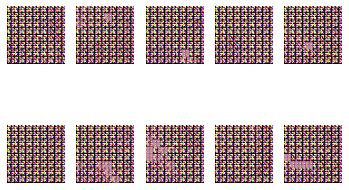

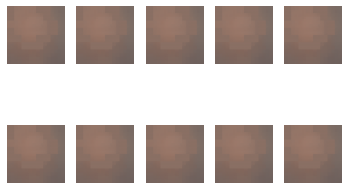

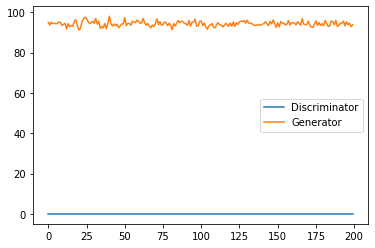

In [ ]:
# Test the model
plot()


# Save the model checkpoint
# if save:
#     torch.save(generator.state_dict(), 'generator.ckpt')
#     torch.save(discriminator.state_dict(), 'discriminator.ckpt')

plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()